In [1]:
# 获取当前工作目录

import os

current_directory = os.getcwd()

print("当前工作目录:", current_directory)

当前工作目录: D:\Data\Shap


In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
          
from sklearn.model_selection import train_test_split   

In [4]:
# 设置字体为新罗马数字

plt.rcParams['font.family'] = 'Times New Roman'

# 处理负号 

plt.rcParams['axes.unicode_minus'] = False

# 忽略警告

import warnings
          
warnings.filterwarnings("ignore")

In [5]:
# 读取数据

df = pd.read_csv('data.csv')

# 删除 NaN 值

df.dropna(inplace=True)

In [6]:
# 划分特征和目标变量 

# 删除 'target' 列

X = df.drop(['target'], axis=1)        

# 获取 'target' 列作为目标变量

y = df['target']    

In [7]:
# 划分训练集和测试集  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    
                                                    random_state=42, 
                                                    
                                                    stratify=df['target'])
# 观察前几行

df.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca  thal  target  
0   0     1       0  
1   3     0       1  
2   2     2       1  
3   0     0       0  
4   0     0       0

In [8]:
# 导入库

import xgboost as xgb

from sklearn.model_selection import GridSearchCV

In [9]:
# XGBoost模型参数

params_xgb = {
          
    'learning_rate': 0.02,            # 学习率，控制每一步的步长，用于防止过拟合。典型值范围：0.01 - 0.1
          
    'booster': 'gbtree',              # 提升方法，这里使用梯度提升树（Gradient Boosting Tree）
          
    'objective': 'binary:logistic',   # 损失函数，这里使用逻辑回归，用于二分类任务
          
    'max_leaves': 127,                # 每棵树的叶子节点数量，控制模型复杂度。较大值可以提高模型复杂度但可能导致过拟合
          
    'verbosity': 1,                   # 控制 XGBoost 输出信息的详细程度，0表示无输出，1表示输出进度信息
          
    'seed': 42,                       # 随机种子，用于重现模型的结果
          
    'nthread': -1,                    # 并行运算的线程数量，-1表示使用所有可用的CPU核心
          
    'colsample_bytree': 0.6,          # 每棵树随机选择的特征比例，用于增加模型的泛化能力
          
    'subsample': 0.7,                 # 每次迭代时随机选择的样本比例，用于增加模型的泛化能力
          
    'eval_metric': 'logloss'          # 评价指标，这里使用对数损失（logloss）
          
}

In [10]:
# 初始化XGBoost分类模型

model_xgb = xgb.XGBClassifier(**params_xgb)

In [11]:
# 定义参数网格，用于网格搜索  

param_grid = {
          
    'n_estimators': [100, 200, 300, 400, 500],  # 树的数量
          
    'max_depth': [3, 4, 5, 6, 7],               # 树的深度
          
    'learning_rate': [0.01, 0.02, 0.05, 0.1],   # 学习率       
}

In [12]:
# 使用GridSearchCV进行网格搜索和k折交叉验证  

grid_search = GridSearchCV(
          
    estimator=model_xgb,
          
    param_grid=param_grid,
          
    scoring='neg_log_loss',  # 评价指标为负对数损失
          
    cv=5,                    # 5折交叉验证
          
    n_jobs=-1,               # 并行计算
          
    verbose=1                # 输出详细进度信息
    
)

In [13]:
# 训练模型
          
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_ra...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=127, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                    

In [14]:
# 输出最优参数   

print("Best parameters found: ", grid_search.best_params_)
          
print("Best Log Loss score: ", -grid_search.best_score_)

Best parameters found:  {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Best Log Loss score:  0.40727758634041217


In [15]:
# 使用最优参数训练模型
          
best_model = grid_search.best_estimator_

In [16]:
from sklearn.metrics import classification_report

# 预测测试集

y_pred = best_model.predict(X_test)

# 输出模型报告， 查看评价指标

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        32
           1       0.88      0.82      0.85        28

    accuracy                           0.87        60
   macro avg       0.87      0.86      0.87        60
weighted avg       0.87      0.87      0.87        60



In [21]:
import joblib

# 保存模型

joblib.dump(best_model , 'XGBoost.pkl')

['XGBoost.pkl']

In [15]:
# 获取XGBoost模型的特征贡献度（重要性） 

feature_importances = best_model.feature_importances_
          
# 将特征和其重要性一起排序   

sorted_indices = np.argsort(feature_importances)[::-1]  # 逆序排列，重要性从高到低
          
sorted_features = X_train.columns[sorted_indices]
          
sorted_importances = feature_importances[sorted_indices]
          
# 绘制按重要性排序的特征贡献性柱状图 

plt.figure(figsize=(10, 6), dpi=1200) 
          
# 使用渐变色，确保最高值为红色

bars = plt.barh(sorted_features, sorted_importances, color="steelblue")

# 添加坐标轴标签

plt.xlabel('Importance',fontsize=10,fontweight='bold')

plt.ylabel('Feature',fontsize=10,fontweight='bold')

# # 设置x轴和y轴的刻度标签字体大小

plt.tick_params(axis='both', labelsize=8)  

# 设置标题

plt.title(f'Xgboost',loc='left', fontsize=10, fontweight='bold')

# 保存图像为 PDF 文件   

plt.gca().invert_yaxis()
          
plt.savefig("Feature_importance_Xgboost.pdf", format='pdf',bbox_inches='tight')
          
# 显示图表   

plt.show()

In [16]:
# 开始计算Shap值

import shap
          
explainer = shap.TreeExplainer(best_model)
          
# 计算shap值为Explanation格式
          
shap_values_Explanation = explainer(X)

In [17]:
# 全局可解释性

# 蜂群图

# 宽度为 10 英寸，高度为 5 英寸,分辨率为1200

plt.figure(figsize=(10, 5), dpi=1200)
          
# 绘制蜂群图，并设置 show=False 以避免直接显示 

shap.plots.beeswarm(shap_values_Explanation,show=False,max_display=13)
   
# 开启网格线

plt.grid(visible=True, linestyle='--', color='gray', alpha=0.1)  

# 添加坐标轴标签

plt.xlabel('SHAP value(impact on AHD)',fontsize=10,fontweight='bold')

plt.ylabel('',fontsize=10,fontweight='bold')

# 设置坐标轴刻度标签的字体大小

plt.tick_params(axis='both', labelsize=8)  # 设置x轴和y轴的刻度标签字体大小

# 设置标题

plt.title(f'',loc='left', fontsize=10, fontweight='bold')

# 保存图像为 PDF 文件

plt.savefig(f"Shap_beeswarm_Xgboost.pdf", format='pdf', bbox_inches='tight')

# 自动调整布局以确保标题显示在图内

plt.tight_layout()

# 显示图片

plt.show()

In [34]:
# 全局可解释性

# 特征重要性图

# 设置 max_display 值

max_display = 13

# 创建图形

plt.figure(figsize=(10, 5), dpi=1200)

# 创建 SHAP 值条形图，并使用 max_display 参数限制最多显示的特征数量

shap.plots.bar(shap_values_Explanation, max_display=max_display, show=False)

# 获取当前图形的 Axes

ax = plt.gca()

# 隐藏条形图后面的数字

for text in ax.texts:
    text.set_visible(False)
    
# 获取 SHAP 值并进行排序

shap_values_sorted = shap_values_Explanation.values.flatten()

sorted_indices = np.argsort(shap_values_sorted)[::-1]  # 逆序排列

sorted_shap_values = shap_values_sorted[sorted_indices][:max_display]

# 创建从蓝色到红色的渐变色

colors = plt.cm.autumn(np.linspace(0, 1, max_display))

# 应用颜色到条形图

for i, bar in enumerate(ax.patches):
    bar.set_facecolor(colors[i])

# 添加坐标轴标签

plt.xlabel('Mean SHAP value(average impact on AHD)',fontsize=10,fontweight='bold')

plt.ylabel('Feature',fontsize=10,fontweight='bold')

# 设置坐标轴刻度标签的字体大小

plt.tick_params(axis='both', labelsize=8)  # 设置x轴和y轴的刻度标签字体大小

# 设置标题

plt.title(f'Xgboost',loc='left', fontsize=10, fontweight='bold')

# 保存图像为 PDF 文件

plt.savefig(f"Shap_importance_Xgboost.pdf", format='pdf', bbox_inches='tight')

plt.tight_layout()

plt.show()

In [20]:
# 局部可解释性

# 单个样本条形图

plt.figure(figsize=(10, 5), dpi=1200)
          
# 创建 SHAP 值条形图，展示数据  

shap.plots.bar(shap_values_Explanation[1], show_data=True, show=False, max_display=13)
          
# 添加坐标轴标签

plt.xlabel('',fontsize=10,fontweight='bold')

plt.ylabel('',fontsize=10,fontweight='bold')

# 设置坐标轴刻度标签的字体大小

plt.tick_params(axis='both', labelsize=8)  # 设置x轴和y轴的刻度标签字体大小

# 设置标题

plt.title(f'',loc='left', fontsize=10, fontweight='bold')

# 保存图像为 PDF 文件 

plt.savefig("SHAP_bar_Xgboost.pdf", format='pdf', bbox_inches='tight')
          
plt.tight_layout()
          
plt.show()

In [21]:
# 局部可解释性

# 个别案例瀑布图

plt.figure(figsize=(10, 5), dpi=1200)
          
# 绘制第1个样本的 SHAP 瀑布图，并设置 show=False 以避免直接显示
          
shap.plots.waterfall(shap_values_Explanation[2], show=False, max_display=13)

# 添加坐标轴标签

plt.xlabel('',fontsize=10,fontweight='bold')

plt.ylabel('',fontsize=10,fontweight='bold')

# 设置x轴和y轴的刻度标签字体大小

plt.tick_params(axis='both', labelsize=8)  

# 设置标题

plt.title(f'',loc='left', fontsize=10, fontweight='bold')
          
# 保存图像为 PDF 文件

plt.savefig("SHAP_waterfall_Xgboost.pdf", format='pdf', bbox_inches='tight')
          
plt.tight_layout()
          
plt.show()

<Figure size 1000x600 with 0 Axes>

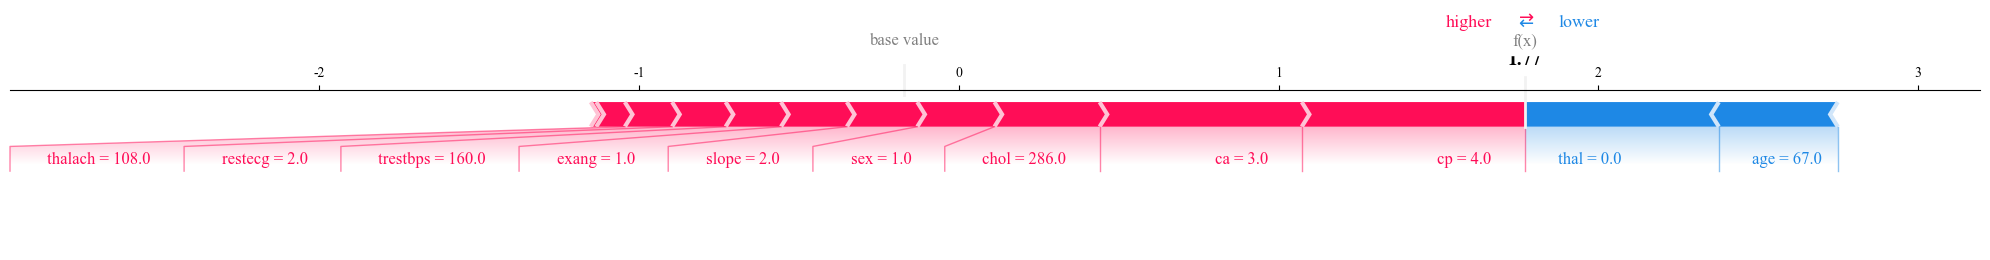

In [22]:
# 局部可解释性

# 单个样本力图

plt.figure(figsize=(10, 6))  

shap.force_plot(shap_values_Explanation[1],matplotlib=True,show=False)

plt.savefig("SHAP_force_Xgboos.pdf", format='pdf', bbox_inches='tight')

plt.tight_layout()

plt.show()

In [42]:
# 局部可解释性

# 多个样本力图

plt.figure(figsize=(10, 6))  

shap.initjs() 

shap.plots.force(shap_values_Explanation[:200])

# 保存图像为 PDF 文件

plt.savefig("SHAP_forceall_Xgboost.pdf", format='pdf', bbox_inches='tight')
          
plt.tight_layout()
          
plt.show()

<Figure size 1000x600 with 0 Axes>

In [25]:

shap_values=explainer.shap_values(X)


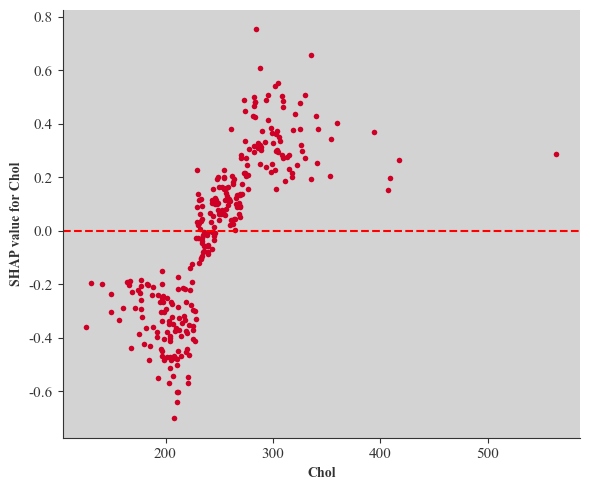

In [26]:
# 局部可解释性

# 变量依赖性图

shap.dependence_plot(
                     'chol', 
    
                     shap_values,
    
                     X,
    
                     interaction_index=None,
    
                     show=False )

# 获取当前的 Axes 对象

ax = plt.gca()

# 设置背景颜色为灰色

ax.set_facecolor('lightgrey')

# 设置散点的颜色为红色

for collection in ax.collections:
    
    collection.set_facecolor('#CF0025')  # 设置点的颜色为红色

# 添加红色虚线

plt.axhline(0, color='red', linestyle='--')

# 添加坐标轴标签

plt.xlabel('Chol',fontsize=10,fontweight='bold')

plt.ylabel('SHAP value for Chol',fontsize=10,fontweight='bold')

# 保存图像为 PDF 文件        
plt.savefig("SHAP_chol_Xgboost.pdf", format='pdf', bbox_inches='tight')
          
plt.tight_layout()

plt.show()

In [27]:
# 创建主图（用来画蜂巢图）

fig, ax1 = plt.subplots(figsize=(10, 8), dpi=1200)

# 在主图上绘制蜂巢图，并保留热度条

shap.summary_plot(shap_values_numpy, X, feature_names=X.columns, plot_type="dot", show=False, color_bar=True)

plt.gca().set_position([0.2, 0.2, 0.65, 0.65])  

# 调整图表位置，留出右侧空间放热度条

# 获取共享的 y 轴

ax1 = plt.gca()# 创建共享 y 轴的另一个图，绘制特征贡献图在顶部x轴

ax2 = ax1.twiny()

shap.summary_plot(shap_values_numpy, X, plot_type="bar", show=False)

plt.gca().set_position([0.2, 0.2, 0.65, 0.65])  # 调整图表位置，与蜂巢图对齐# 在顶部 X 轴添加一条横线

ax2.axhline(y=13, color='gray', linestyle='-', linewidth=1)  # 注意y值应该对应顶部

# 调整透明度

bars = ax2.patches  # 获取所有的柱状图对象

for bar in bars:    
    
    bar.set_alpha(0.2)  # 设置透明度
    
# 设置两个x轴的标签

ax1.set_xlabel('Shapley Value Contribution (Bee Swarm)', fontsize=12)

ax2.set_xlabel('Mean Shapley Value (Feature Importance)', fontsize=12)# 移动顶部的 X 轴，避免与底部 X 轴重叠

ax2.xaxis.set_label_position('top')  # 将标签移动到顶部

ax2.xaxis.tick_top()  # 将刻度也移动到顶部# 设置y轴标签

ax1.set_ylabel('Features', fontsize=12)

plt.tight_layout()

plt.savefig("SHAP_combined_with_top_line_corrected.pdf", format='pdf', bbox_inches='tight')

plt.show()